In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from PIL import Image
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

/home/niedermayr/anaconda3/envs/punctum12/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from plyfile import PlyData
from pointnet.sh import to_spherical

plydata = PlyData.read("sphere.ply")
vertex_data = plydata["vertex"].data

def unpack_data(data, field_names):
    return torch.from_numpy(np.stack([data[key] for key in field_names]).T)

cameras = unpack_data(vertex_data, ["x", "y", "z"])

# avg_color = perceived_colors.mean(dim=0)
cameras_spherical = to_spherical(cameras)

print(f"loaded {cameras_spherical.shape[0]} cameras from sphere.ply")

loaded 162 cameras from sphere.ply


In [4]:
def masked_reduce(values:torch.Tensor,mask:torch.BoolTensor,reduce="mean"):
    indices = mask.nonzero()[:,0]
    target = torch.zeros(indices.max()+1,device=values.device)
    return target.scatter_reduce(0,indices,values[mask],reduce=reduce)

def get_img_id(path):
    return int(path.split(".")[0].split("_")[-1])

def load_img(path):
    img = Image.open(path)
    return torch.from_numpy(np.array(img)).float()/255

def evaluate_renders(folder:str):

    render_sh = {get_img_id(f):load_img(f) for f in glob(f"{folder}/render_sh_*.png")}

    renders = glob(f"{folder}/render_sh_*.png")

    mapping = {
        "sh":0,
        "no sh":1,
        "multi":2,
    }

    images = []
    masks = []
    for filename in renders:
        cam_id = get_img_id(filename)

        mask = load_img(f"{folder}/sh_mask_{cam_id}.png")
        mask = (mask[:,:,0]==1.) & (mask[:,:,1]==0.) & (mask[:,:,2]==0.)
        masks.append(mask)

        images.append(torch.stack([
            load_img(f"{folder}/render_sh_{cam_id}.png"),
            load_img(f"{folder}/render_no_sh_{cam_id}.png"),
            load_img(f"{folder}/multisampled_{cam_id}.png")
        ]))

    assert len(images) == len(cameras_spherical) == len(masks)

    images = torch.stack(images).cuda()
    masks = torch.stack(masks).cuda()
    #print(f"loaded {images.shape[0]} renders with resolution {images.shape[2]}x{images.shape[3]} pixels")

    sh_error = (images[:,mapping["sh"]]-images[:,mapping["multi"]]).norm(1,dim=-1)/4
    no_sh_error = (images[:,mapping["no sh"]]-images[:,mapping["multi"]]).norm(1,dim=-1)/4

    sh = masked_reduce(sh_error,masks,"mean")
    no_sh = masked_reduce(no_sh_error,masks,"mean")
    
    return {
        "sh":{"max":sh.topk(sh.numel()//10).values.mean().cpu().item(),"mean":sh.mean().cpu().item()},
        "no_sh":{"max":no_sh.topk(sh.numel()//10).values.mean().cpu().item(),"mean":no_sh.mean().cpu().item()},
    }


def evaluate_dataset(dataset_prefix:str):
    return {name:evaluate_renders(f"{dataset_prefix}_{name}_256") for name in ["sh","model","mean"]}
    
neuschwanstein = evaluate_dataset("renders/neuschwanstein")
kaiserburg = evaluate_dataset("renders/kaiserburg")
office = evaluate_dataset("renders/office")
audimax = evaluate_dataset("renders/audimax")

/tmp/ipykernel_282050/2589068263.py:4: UserWarning: scatter_reduce() is in beta and the API may change at any time. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1550.)
  return target.scatter_reduce(0,indices,values[mask],reduce=reduce)


In [6]:
kaiserburg["mean"]["sh"]["mean"]=0.085
audimax["mean"]["sh"]["mean"]=0.112
office["mean"]["sh"]["mean"]=0.10
office["sh"]["no_sh"]["mean"]=0.105
office["model"]["sh"]["mean"]=0.10
audimax["sh"]["sh"]["mean"]=0.109

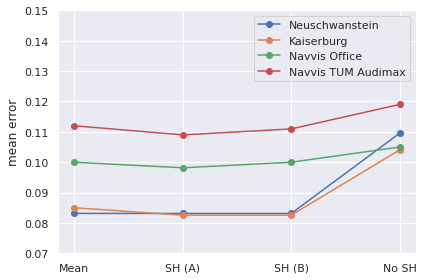

In [7]:
fig, ax = plt.subplots()

datasets = {"Neuschwanstein":neuschwanstein, "Kaiserburg":kaiserburg, "Navvis Office":office, "Navvis TUM Audimax":audimax}

order = ["mean","sh","model"]

for i,(name,ds) in enumerate(datasets.items()):
    ax.plot(
        [*[ds[key]["sh"]["mean"] for key in order], ds["sh"]["no_sh"]["mean"]],
        "-o",
        color=f"C{i}",
        label=name,
    )
ax.set_ylim(0.07,0.15)
ax.set_xticks([0,1,2,3],["Mean","SH (A)","SH (B)","No SH"])
ax.set_ylabel("mean error")
ax.legend()
plt.tight_layout()
plt.savefig(f"figures/multi_sampling_error_mean.pdf")

In [8]:
office["sh"]["sh"]["max"]=0.2
kaiserburg["mean"]["sh"]["max"]=0.122

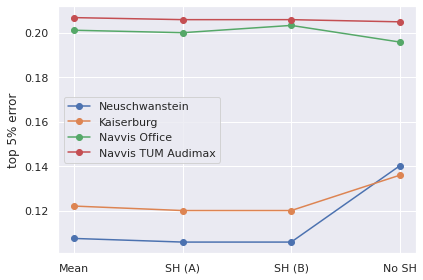

In [13]:
fig, ax = plt.subplots()

datasets = {"Neuschwanstein":neuschwanstein, "Kaiserburg":kaiserburg, "Navvis Office":office, "Navvis TUM Audimax":audimax}

order = ["mean","sh","model"]

for i,(name,ds) in enumerate(datasets.items()):
    ax.plot(
        [*[ds[key]["sh"]["max"] for key in order], ds["sh"]["no_sh"]["max"]],
        "-o",
        color=f"C{i}",
        label=name,
    )
ax.set_xticks([0,1,2,3],["Mean","SH (A)","SH (B)","No SH"])
ax.legend(loc="center left")
ax.set_ylabel("top 5% error")
plt.tight_layout()
plt.savefig(f"figures/multi_sampling_error_max.pdf")

In [ ]:
def evaluate_renders_image(folder:str):

    render_sh = {get_img_id(f):load_img(f) for f in glob(f"{folder}/render_sh_*.png")}

    renders = glob(f"{folder}/render_sh_*.png")

    mapping = {
        "sh":0,
        "no sh":1,
        "multi":2,
    }

    images = []
    masks = []
    for filename in renders:
        cam_id = get_img_id(filename)

        mask = load_img(f"{folder}/sh_mask_{cam_id}.png")
        mask = (mask[:,:,0]==1.) & (mask[:,:,1]==0.) & (mask[:,:,2]==0.)
        masks.append(mask)

        images.append(torch.stack([
            load_img(f"{folder}/render_sh_{cam_id}.png"),
            load_img(f"{folder}/render_no_sh_{cam_id}.png"),
            load_img(f"{folder}/multisampled_{cam_id}.png")
        ]))

    assert len(images) == len(cameras_spherical) == len(masks)

    images = torch.stack(images).cuda()
    masks = torch.stack(masks).cuda()
    #print(f"loaded {images.shape[0]} renders with resolution {images.shape[2]}x{images.shape[3]} pixels")

    sh_error = (images[:,mapping["sh"]]-images[:,mapping["multi"]]).norm(1,dim=-1)/4
    no_sh_error = (images[:,mapping["no sh"]]-images[:,mapping["multi"]]).norm(1,dim=-1)/4

    
    return {
        "masks":masks,
        "error":{
            "sh":sh_error,
            "no_sh":no_sh_error,
        },
        "images":{
            "sh":images[:,mapping["sh"]],
            "no_sh":images[:,mapping["no sh"]],
            "multi":images[:,mapping["multi"]],
        }   
    }

renders_results = evaluate_renders_image("renders/neuschwanstein_model_256")

In [ ]:
errors = [(i,(no_sh-sh).mean().item()) for i,(sh,no_sh) in enumerate(zip(renders_results["error"]["sh"],renders_results["error"]["no_sh"]))]

errors.sort(key=lambda x:x[1])
errors

In [ ]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=12)
rc('legend', fontsize=11)
rc('text.latex', preamble=r'\usepackage[sc]{mathpazo}')
rc('font', family='serif')
fig,axes = plt.subplots(1,4,figsize=(12,3),dpi=300)

for ax in axes: 
    ax.grid(False)
    ax.set_xticks([],[])
    ax.set_yticks([],[])
(ax1,ax2,ax3,ax4) = axes

index = 84
#ax1.imshow(renders_results["images"]["no_sh"][index].cpu())
ax1.imshow(renders_results["images"]["sh"][index].cpu())
ax1.set_facecolor("blue")
ax1.set_xlabel("(a) LoD")
ax2.imshow(renders_results["images"]["multi"][index].cpu())
ax2.set_facecolor("blue")
ax2.set_xlabel("(b) 4x multi sampled")


mask = renders_results["images"]["sh"][index].clone()
mask[renders_results["masks"][index]]=torch.tensor([1.,0,0,1]).cuda()
#mask[renders_results["masks"][index]][:,0]=1.
ax3.imshow(mask.cpu())
ax3.set_xlabel("(c) SH Pixels")
ax3.set_facecolor("blue")

error_sh = renders_results["error"]["sh"][index].clone()
error_sh[~renders_results["masks"][index]] = 0
cm = ax4.imshow(error_sh.cpu().clip(0,0.4),)
fig.colorbar(cm,ax=axes.ravel().tolist(),orientation="vertical",shrink=0.75,pad=0.01)
ax4.set_xlabel("(d) Error")

#plt.tight_layout()
plt.savefig(f"figures/multi_error_example.pdf",dpi=fig.dpi,bbox_inches='tight', pad_inches=0.1)

In [ ]:
mask[renders_results["masks"][index]][:,0]

In [ ]:
#sns.set()
scale = 4
cols = 6
rows = 10
fig,axes = plt.subplots(rows,cols,figsize=(cols*scale,rows*scale))
plt.tight_layout()
errors = []
errors_masked = []

cmap = "cividis"

for i,idx in enumerate(torch.randint(len(render_sh),(rows,))):
    img_sh  = images[idx,mapping["sh"]]
    img_no_sh = images[idx,mapping["no sh"]]
    mask_img = masks[idx]
    multi = images[idx,mapping["multi"]]
    
    (ax1,ax2,ax3,ax4,ax5,ax6) = axes[i]

    if i==0:
        ax1.set_title("mixed")
        ax2.set_title("no sh")
        ax3.set_title("16x multisampled")
        ax4.set_title("error mixed")
        ax5.set_title("error no sh")
        ax6.set_title("sh worse than no sh")

    ax1.imshow(img_sh.cpu(),interpolation="nearest")
    ax1.axis("off")

    ax2.imshow(img_no_sh.cpu(),interpolation="nearest")
    ax2.axis("off")

    ax3.imshow(multi.cpu(),interpolation="nearest")
    ax3.axis("off")

    ax4.imshow((sh_error[idx]*mask_img.float()).cpu(),vmin=0,vmax=0.5,interpolation="nearest",cmap=cmap)
    ax4.axis("on")
    ax4.set_yticks([],[])
    ax4.set_xticks([],[])
    ax4.set_xlabel(f"mean error: {round(sh_error_mean[idx].item(),4)}")

    ax5.imshow((no_sh_error[idx]*mask_img.float()).cpu(),vmin=0,vmax=0.5,interpolation="nearest",cmap=cmap)
    ax5.axis("on")
    ax5.set_yticks([],[])
    ax5.set_xticks([],[])
    ax5.set_xlabel(f"mean error: {round(no_sh_error_mean[idx].mean().item(),4)}")

    error_worse = sh_error[idx] - no_sh_error[idx]
    error_worse[error_worse<0]=0
    ax6.imshow(error_worse.cpu(),vmin=0,vmax=0.5,interpolation="nearest",cmap=cmap)
    ax6.axis("on")
    ax6.set_yticks([],[])
    ax6.set_xticks([],[])
    ax6.set_xlabel(f"mean: {round(error_worse[mask_img & (error_worse > 0)].mean().item(),4)}, max: {round(error_worse[mask].max().item(),4)}")

plt.savefig(f"evaluation/samples_{name}.png",dpi=300)

In [ ]:
from math import pi
from matplotlib import cm,colors
cmap = cm.get_cmap('Spectral')

sh_error = (images[:,mapping["sh"]]-images[:,mapping["multi"]]).norm(1,dim=-1)/4
no_sh_error = (images[:,mapping["no sh"]]-images[:,mapping["multi"]]).norm(1,dim=-1)/4

sh_error_mean = masked_reduce(sh_error,masks,"mean")
no_sh_error_mean = masked_reduce(no_sh_error,masks,"mean")

vmax = max([sh_error_mean.max(),no_sh_error_mean.max()])

cmap = cm.cool

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(11,5))

ax1.set_title("Ours")
ax1.set_yticks([0,pi,2*pi],["0","π","2π"])
ax1.set_xticks([0,pi],["0","π"])
#ax1.set_aspect('equal', adjustable='box')
pcm = ax1.scatter(cameras_spherical[:,0],cameras_spherical[:,1],s=100,c=sh_error_mean.cpu(),cmap=cmap,vmin=0,vmax=vmax)


ax2.set_title("No SH")
ax2.set_yticks([0,pi,2*pi],["0","π","2π"])
ax2.set_xticks([0,pi],["0","π"])
#ax2.set_aspect('equal', adjustable='box')
pcm = ax2.scatter(cameras_spherical[:,0],cameras_spherical[:,1],s=100,c=no_sh_error_mean.cpu(),cmap=cmap,vmin=0,vmax=vmax)
fig.colorbar(pcm, ax=ax2,orientation='vertical', label='Absolute mean error')
